# 01 — Rossby Wave Breaking & Derivative Operators

This notebook loads a **real ERA5 blocking event** and demonstrates:

1. Grid setup (`NHGrid`)
2. PV derivative computation (`ddx`, `ddy`, `ddp`)
3. Rossby-wave-breaking (RWB) detection (`detect_rwb_events`)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pvtend import NHGrid, ddx, ddy, ddp, R_EARTH
from pvtend.rwb import detect_rwb_events, RWBConfig
from pvtend.io import load_npz_patch
from pvtend.constants import DEFAULT_LEVELS

## 1  Load a sample blocking event

In [2]:
# ── data path (single event at onset, dh=0) ──
DATA_ROOT = "/net/flood/data2/users/x_yan/tempest_extreme_4_basis/outputs_tmp"
npz_path = f"{DATA_ROOT}/blocking_tmp/onset/dh=+0/track_100_1992080507_dh+0.npz"

d = dict(np.load(npz_path))
lat = d["lat_vec"]          # (29,)
lon = d["lon_vec_unwrapped"] # (49,)
levels = d["levels"]         # (9,) hPa
X_rel, Y_rel = d["X_rel"], d["Y_rel"]  # relative-degree coords

print(f"Patch shape  : lat {lat.shape}, lon {lon.shape}")
print(f"Lat range    : {lat.min():.1f}° – {lat.max():.1f}°")
print(f"Lon range    : {lon.min():.1f}° – {lon.max():.1f}°")
print(f"Levels (hPa) : {levels}")
print(f"Track ID     : {int(d['track_id'])}")
print(f"Timestamp    : {str(d['ts'])}")

Patch shape  : lat (29,), lon (49,)
Lat range    : 27.0° – 69.0°
Lon range    : -28.5° – 43.5°
Levels (hPa) : [1000  850  700  500  400  300  250  200  100]
Track ID     : 100
Timestamp    : 1992-08-05 07:00:00


## 2  Grid helper

In [3]:
grid = NHGrid(lat=lat[::-1], lon=lon)   # NHGrid expects descending lat
dx_arr = grid.dx_arr[::-1]              # match ascending-lat data order
dy    = grid.dy
print(f"dy = {dy:.0f} m")
print(f"dx range = {dx_arr.min():.0f} – {dx_arr.max():.0f} m")

dy = 166792 m
dx range = 59773 – 148613 m


## 3  Compute PV derivatives and compare with stored values

In [4]:
pv_3d = d["pv_3d"]  # (9, 29, 49)

# Compute ∂PV/∂x, ∂PV/∂y with pvtend operators
pv_dx_computed = np.stack([ddx(pv_3d[k], dx_arr, periodic=False) for k in range(9)])
pv_dy_computed = np.stack([ddy(pv_3d[k], dy) for k in range(9)])

# Pre-computed values from the NPZ (weighted-average of 300/250/200 hPa)
pv_dx_stored = d["pv_dx_3d"]
pv_dy_stored = d["pv_dy_3d"]

# Agreement check (interior points)
rel_err_dx = np.nanmean(np.abs(pv_dx_computed[:, 2:-2, 2:-2] - pv_dx_stored[:, 2:-2, 2:-2])) / (
    np.nanmean(np.abs(pv_dx_stored[:, 2:-2, 2:-2])) + 1e-30)
rel_err_dy = np.nanmean(np.abs(pv_dy_computed[:, 2:-2, 2:-2] - pv_dy_stored[:, 2:-2, 2:-2])) / (
    np.nanmean(np.abs(pv_dy_stored[:, 2:-2, 2:-2])) + 1e-30)
print(f"Relative error  ∂PV/∂x : {rel_err_dx:.4e}")
print(f"Relative error  ∂PV/∂y : {rel_err_dy:.4e}")

Relative error  ∂PV/∂x : 0.0000e+00
Relative error  ∂PV/∂y : 3.7223e-08


In [5]:
# Pressure derivative
plevs_pa = levels.astype(float) * 100.0  # hPa → Pa
pv_dp_computed = ddp(pv_3d, plevs_pa)

pv_dp_stored = d["pv_dp_3d"]
rel_err_dp = np.nanmean(np.abs(pv_dp_computed[1:-1] - pv_dp_stored[1:-1])) / (
    np.nanmean(np.abs(pv_dp_stored[1:-1])) + 1e-30)
print(f"Relative error  ∂PV/∂p : {rel_err_dp:.4e}")

Relative error  ∂PV/∂p : 2.9207e-01


## 4  Visualise PV & its gradients at 300 hPa

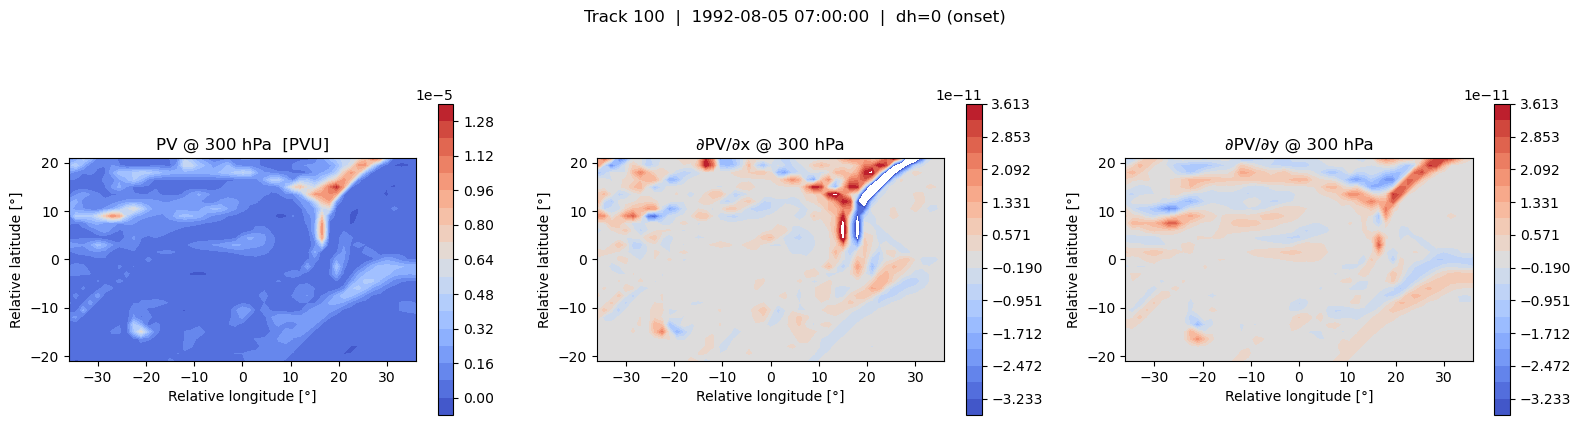

In [6]:
ilev = np.argmin(np.abs(levels - 300))  # 300 hPa index

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
kw = dict(cmap="coolwarm", origin="lower")

im0 = axes[0].contourf(X_rel[0], Y_rel[:, 0], pv_3d[ilev], levels=20, **kw)
axes[0].set_title("PV @ 300 hPa  [PVU]")
plt.colorbar(im0, ax=axes[0], shrink=0.8)

vmax = np.nanpercentile(np.abs(pv_dx_stored[ilev]), 98)
im1 = axes[1].contourf(X_rel[0], Y_rel[:, 0], pv_dx_stored[ilev],
                        levels=np.linspace(-vmax, vmax, 20), **kw)
axes[1].set_title("∂PV/∂x @ 300 hPa")
plt.colorbar(im1, ax=axes[1], shrink=0.8)

im2 = axes[2].contourf(X_rel[0], Y_rel[:, 0], pv_dy_stored[ilev],
                        levels=np.linspace(-vmax, vmax, 20), **kw)
axes[2].set_title("∂PV/∂y @ 300 hPa")
plt.colorbar(im2, ax=axes[2], shrink=0.8)

for ax in axes:
    ax.set_xlabel("Relative longitude [°]")
    ax.set_ylabel("Relative latitude [°]")
    ax.set_aspect("equal")
fig.suptitle(f"Track {int(d['track_id'])}  |  {str(d['ts'])}  |  dh=0 (onset)", y=1.02)
fig.tight_layout()
plt.show()

## 5  RWB detection on the PV anomaly field

In [7]:
# Use the weighted-average PV anomaly (2D)
pv_anom_2d = d["pv_anom"]       # (29, 49)
x_coords = X_rel[0, :]          # 1D longitude coordinates
y_coords = Y_rel[:, 0]          # 1D latitude coordinates

cfg = RWBConfig(try_levels=200, max_keep=8, min_vertices=20, area_min_deg2=20.0)
rwb_events = detect_rwb_events(pv_anom_2d, x_coords, y_coords, cfg=cfg)
print(f"Detected {len(rwb_events)} RWB events")
for ev in rwb_events:
    print(f"  {ev['wb_type']:3s}  area={ev['area']:.1f} deg²  "
          f"centroid=({ev['centroid'][0]:.1f}°, {ev['centroid'][1]:.1f}°)")

Detected 1 RWB events
  AWB  area=25.6 deg²  centroid=(8.7°, 3.0°)


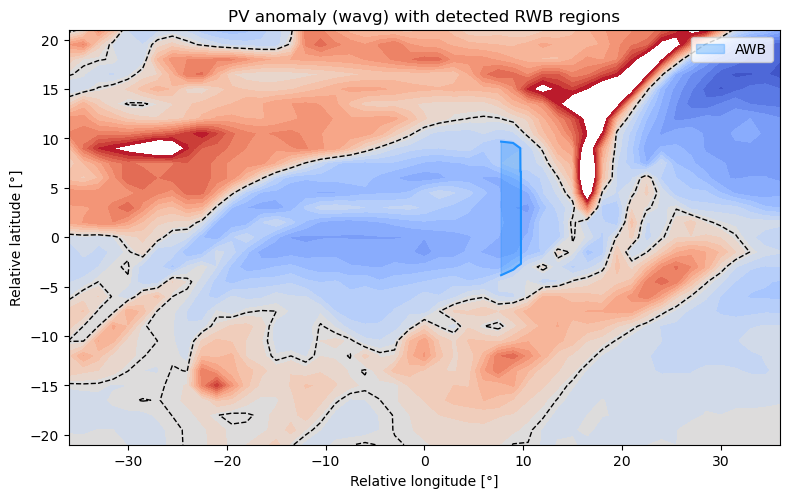

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
vmax = np.nanpercentile(np.abs(pv_anom_2d), 98)
ax.contourf(x_coords, y_coords, pv_anom_2d,
            levels=np.linspace(-vmax, vmax, 24), cmap="coolwarm")
ax.contour(x_coords, y_coords, pv_anom_2d, levels=[0], colors="k",
           linewidths=1.0, linestyles="--")

colors = {"AWB": "dodgerblue", "CWB": "tomato", "UNK": "gray"}
for ev in rwb_events:
    c = colors.get(ev["wb_type"], "gray")
    ax.fill(ev["polygon_x"], ev["polygon_y"], alpha=0.3, color=c,
            label=ev["wb_type"])
    ax.plot(ev["polygon_x"], ev["polygon_y"], color=c, lw=1.5)

ax.set_xlabel("Relative longitude [°]")
ax.set_ylabel("Relative latitude [°]")
ax.set_title("PV anomaly (wavg) with detected RWB regions")
# deduplicate legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
if by_label:
    ax.legend(by_label.values(), by_label.keys(), loc="upper right")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

## Summary

- **`ddx` / `ddy` / `ddp`** reproduce the pre-computed derivatives stored in the NPZ patches.
- **`detect_rwb_events`** identifies anticyclonic and/or cyclonic wave-breaking lobes
  from the overturning PV contours on an event-centred patch.